<font size=25, color='#ED1F24'>Laboratory 8

<font size=25, color='#ED1F24'>CNNs Applications

## Recap from Lab5 and Lab7
*   Convolutions (purpose, tasks examples)
*   CNN layers (efficiency vs Linear layers)
*   Transformers



## Today
Focus on reusing existing models/available code
*   ResNet and ViT to classify CIFAR-10 images
*   Adversarial Examples
*   Main tasks in Computer Vision
    * Classification
    * Detection
    * Segmentation
*   Fun: use existing Computer Vision models for cool tasks



* <font color='#ED1F24'>**Q:** </font> Why is Computer Vision important? What else?

# Part I: ResNet architecture on CIFAR-10
* Explore CIFAR-10 dataset
* Train the ResNet architecture, modify it and replace the backbone


[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)
* (small) image classification dataset, largely used for testing ML concepts
* 32 x 32 images, 10 balanced classes, 50.000 train - 10.000 test

<div>
<img src=https://drive.google.com/uc?id=1Cf8TpFXEcJg1Q3UDj1lIfku-CqzbFpPh width="600"/>
<div>

Other [datasets from PyTorch](https://pytorch.org/vision/stable/datasets.html#image-classification) (eg. Fashion MNIST - also a small one)

## ResNet18

We start from some [github code](https://github.com/kuangliu/pytorch-cifar) that trains a resnet model on CIFAR-10.

In [1]:
%matplotlib inline
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Code from https://github.com/kuangliu/pytorch-cifar

# imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import torchvision.models as models

from google.colab import drive

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from tqdm import tqdm

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Transformations and Augmentations
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Datasets and dataloaders
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)



==> Preparing data..


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


In [27]:
# initializations
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("DEVICE", device)
best_acc = 0  # best test accuracy

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
net = models.resnet18(pretrained=True)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

DEVICE cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# Training
# AMP scaler and Mixed precision used for faster runtime
scaler = torch.cuda.amp.GradScaler()  # AMP scaler

def train(epoch, net):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, targets in tqdm(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device):  # Mixed precision
            outputs = net(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

def test(epoch, net):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device):  # Mixed precision
                outputs = net(inputs)
                loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    if acc > best_acc:
        print('Saving %d - Valid Acc: %.2f' % (epoch, acc))
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }

        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

<ipython-input-30-ff744974bc3a>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # AMP scaler


In [24]:
for epoch in range(5):
    train(epoch, net)
    test(epoch, net)
    scheduler.step()

    # not pretrained -> 66.06 %
    # pretrained -> 81.15
    # MyResNet -> 65.13


Epoch: 0


100%|██████████| 40/40 [00:02<00:00, 15.35it/s]


Saving 0 - Valid Acc: 68.47

Epoch: 1


100%|██████████| 40/40 [00:04<00:00,  9.30it/s]


Saving 1 - Valid Acc: 75.69

Epoch: 2


100%|██████████| 40/40 [00:02<00:00, 16.21it/s]


Saving 2 - Valid Acc: 76.31

Epoch: 3


100%|██████████| 40/40 [00:02<00:00, 16.15it/s]


Saving 3 - Valid Acc: 79.32

Epoch: 4


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Saving 4 - Valid Acc: 81.15


<font color='#ED1F24'>**TODO:** </font> Note the performance after the first 5 epochs for both pretrained and "from scratch" resnet versions.

`net = models.resnet18(pretrained=True)` vs `net = models.resnet18(pretrained=False)`

## Modify ResNet18

* Observe the architecture
* <font color='#ED1F24'>**Q:** </font> Describe the BasicBlock layers (their purpose, output shape, number of parameters)
  * Conv2d
    * output shape: $[(W_{in} − kernel_{size} + 2*pad) / stride] + 1$
    * number of parameters: $(W_{in} * H_{in} * C_{in}) * C_{out} + C_{out}$
<!-- $out(N_i, {C_{out}}_{j})=bias({C_{out}}_{j}) + \sum_{k=0}^{C_{in}-1}weight({C_{out}}_{j}, k)\ast input(N_i, k)$ -->
  * BatchNorm2d
    * number of parameters: $ 2 * C_{in}$
  * ReLU
* <font color='#ED1F24'>**Q:** </font> How many deep layers?



<div>
<img src=https://drive.google.com/uc?id=1iS5XFyL9TO7i2v2qLQsoGVP8EyJsi6qp  width="200"/>
<img src=https://drive.google.com/uc?id=1RgzZc5Et_ALAjfU_0d2VlT4NAwVTe_C_  width="600"/>
<img src=https://drive.google.com/uc?id=1wUjV3vgiyK7bWiEn3DddV1v8lCcdehR1  width="804"/>
<!-- <img src=https://drive.google.com/uc?id=1YjxwUdrA_QQS8P7ZuMZEMM09TQTkMgY_  width="700"
/> -->
<div>

### Skip connections
Used in architectures like ResNets and Transformers, they allow the input of a layer to bypass the transformation and be added directly to its output. Main problems of deep neural networks as they get deeper: *vanishing gradient*

**Forward pass**:  
Skip connections preserve the original input signal, helping prevent information degradation across layers. This is crucial in deep networks where representations can easily become distorted or overspecialized.

**Backpropagation**:  
Skip connections provide an alternate gradient path through the identity mapping, ensuring stable training and better gradient flow. This helps reduce the risk of vanishing gradients, especially in deep architectures.

### Skip connections in action

Assume a residual block:

$$
y = F(x) + x
$$


To compute the gradient of the loss \( L \) with respect to the input \( x \), apply the chain rule:

$$
\frac{dL}{dx} = \frac{dL}{dy} \cdot \frac{dy}{dx}
$$

Since:

$$
y = F(x) + x
$$

Then:

$$
\frac{dy}{dx} = \frac{dF(x)}{dx} + \frac{dx}{dx} = \frac{dF(x)}{dx} + I
$$

So the total gradient becomes:

$$
\frac{dL}{dx} = \frac{dL}{dy} \cdot \left( \frac{dF(x)}{dx} + I \right)
$$

Distributing the terms:

$$
\frac{dL}{dx} = \frac{dL}{dy} \cdot \frac{dF(x)}{dx} + \frac{dL}{dy} \cdot I
$$

$$
\frac{dL}{dx} = \text{Gradient through } F(x) + \text{Gradient through skip connection}
$$



In [11]:
print(net)

# ResNet(
#     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     (relu): ReLU(inplace=True)
#     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

# (0): BasicBlock(
#         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         (relu): ReLU(inplace=True)
#         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       )

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

<font color='#ED1F24'>**TODO:** </font> Replace the ResNet18 implementation with your code (just copy the [PyTorch code](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py) in colab and call this code instead of the initial one). Inspect the output sizes.

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


<font color='#ED1F24'>**TODO:** </font> Remove the residual connection in ResNet18, retrain and observe the performance differences.

Remove the line : `out += identity`

In [25]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor

# from ..transforms._presets import ImageClassification
# from ..utils import _log_api_usage_once
# from ._api import register_model, Weights, WeightsEnum
# from ._meta import _IMAGENET_CATEGORIES
# from ._utils import _ovewrite_named_param, handle_legacy_interface


__all__ = [
    "ResNet",
    "ResNet18_Weights",
    "ResNet34_Weights",
    "ResNet50_Weights",
    "ResNet101_Weights",
    "ResNet152_Weights",
    "ResNeXt50_32X4D_Weights",
    "ResNeXt101_32X8D_Weights",
    "ResNeXt101_64X4D_Weights",
    "Wide_ResNet50_2_Weights",
    "Wide_ResNet101_2_Weights",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "resnext101_64x4d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # out += identity
        out = self.relu(out)

        return out


class MyResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)



In [33]:
my_net = MyResNet(BasicBlock, [2, 2, 2, 2])
my_net = my_net.to(device)

# random_input = torch.rand(10, 3, 32, 32).to(device)
# output = my_net(random_input)
# print(output.shape)

optimizer = optim.SGD(my_net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

for epoch in range(5):
    train(epoch, my_net)
    test(epoch, my_net)
    scheduler.step()


Epoch: 0


100%|██████████| 40/40 [00:02<00:00, 15.74it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Saving 0 - Valid Acc: 46.96

Epoch: 1


100%|██████████| 40/40 [00:02<00:00, 15.80it/s]


Saving 1 - Valid Acc: 53.22

Epoch: 2


100%|██████████| 40/40 [00:03<00:00, 11.16it/s]


Saving 2 - Valid Acc: 59.91

Epoch: 3


100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


Saving 3 - Valid Acc: 61.01

Epoch: 4


100%|██████████| 40/40 [00:02<00:00, 16.01it/s]


Saving 4 - Valid Acc: 65.13


## Visual Transformer (ViT)

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*l37va2Mu8Snx6LLb13430A.png" width=700>

Replacing the model with ViT-B/16

<font color='#ED1F24'>**TODO:** </font> Note the performance after 1 epoch for both pretrained and "from scratch" ViT versions.

`net = models.vit_b_16(pretrained=True)` vs `net = models.vit_b_16(pretrained=False)`

Nota bene: To minimize the computing overhead, we freeze the whole network with the exception of the last layer


In [42]:
# Model
net = models.vit_b_16(pretrained=False)

# Freeze network
for param in net.parameters():
    param.requires_grad = False

# Redefine last layer
net.heads = nn.Linear(768, 10)

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [43]:
# Transformations and Augmentations
print('==> Preparing data..')
# TODO: complete the transforms for train and test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Datasets and dataloaders
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)



==> Preparing data..


In [45]:
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
best_acc = 0
for epoch in range(1):
    train(epoch, net)
    test(epoch, net)
    scheduler.step()

    # transforms.Resize((224, 224)),
    # pretrained -> 94.69 %
    # not pretrained -> 37.81 %


Epoch: 0


100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Saving 0 - Valid Acc: 37.81


Visualize attention maps. Attention maps denote to which parts of an image the transformers ""attends"(is focusing on when making the prediction)

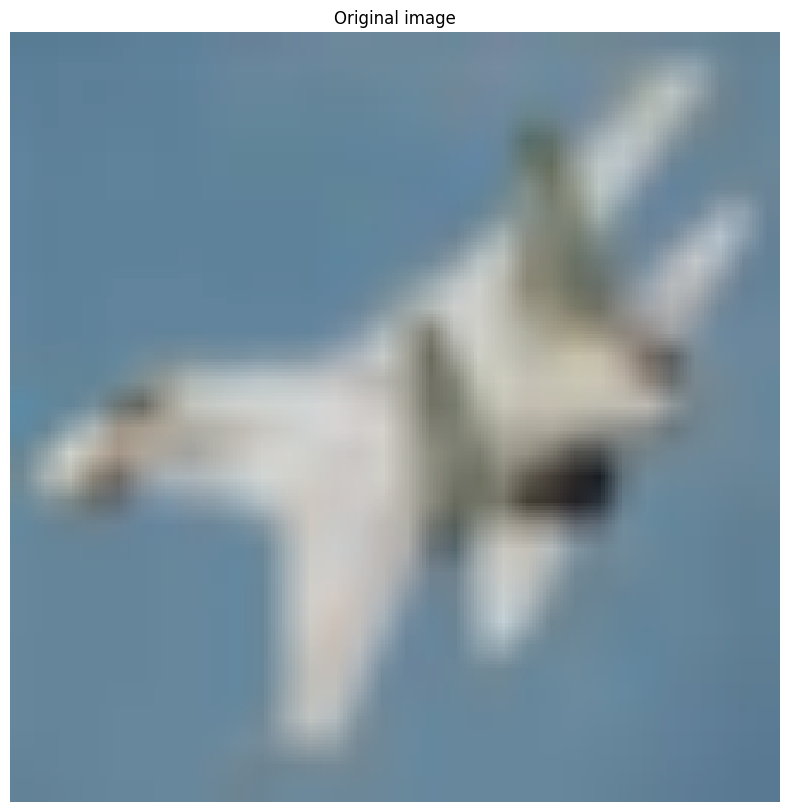

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

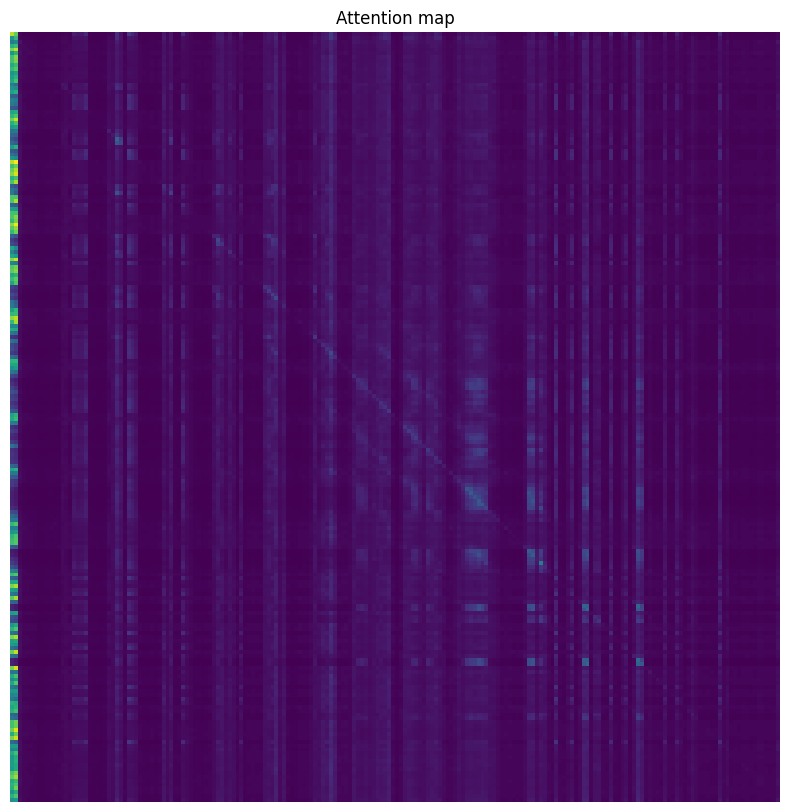

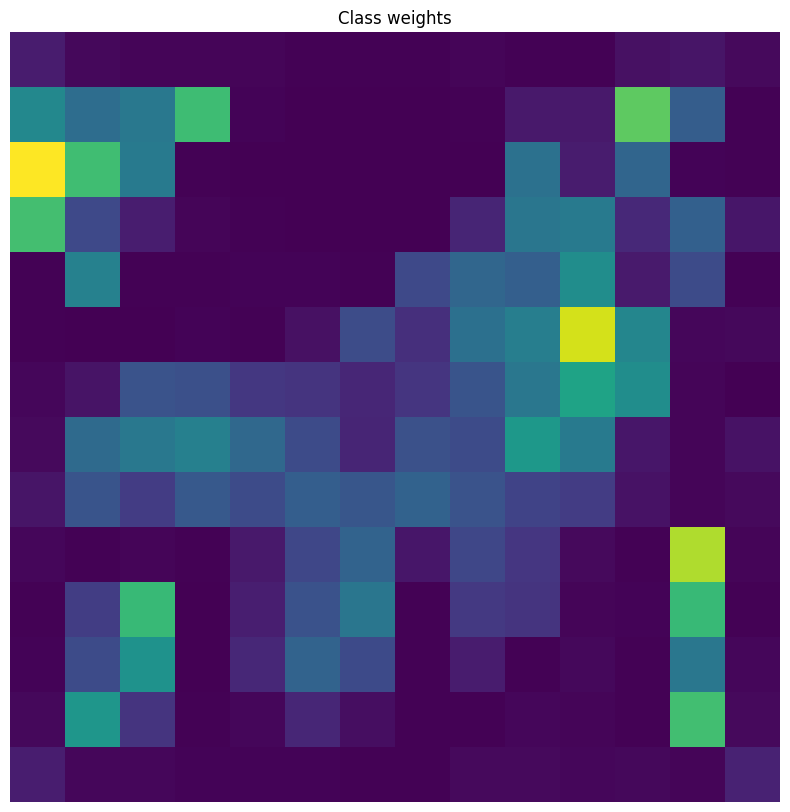

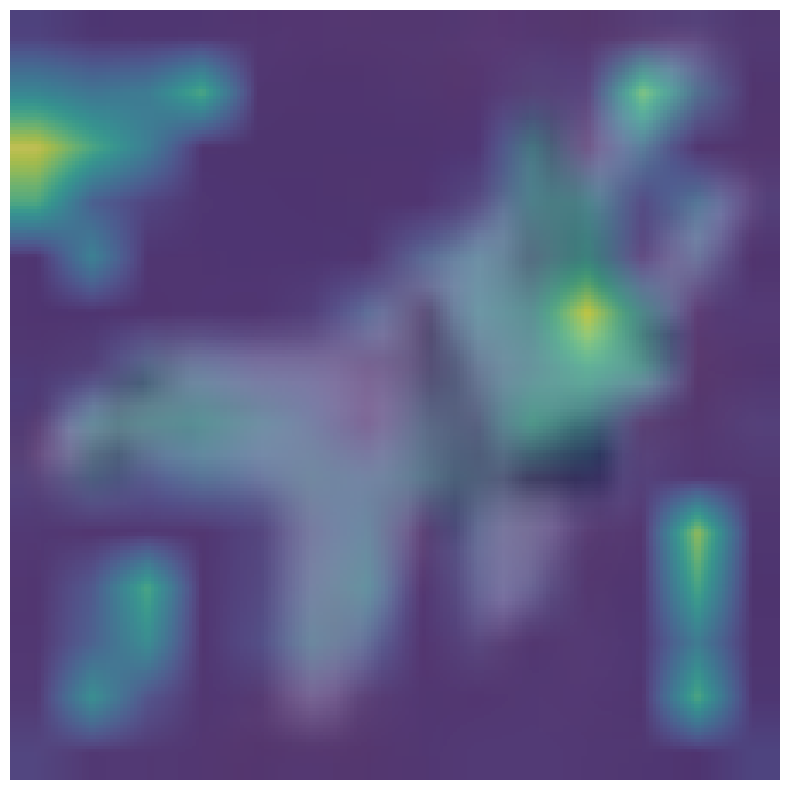

In [46]:
def show_img(img, title):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

reverse_normalize = transforms.Compose([
    transforms.Normalize(mean=[-0.4914 / 0.2023, -0.4822 / 0.1994, -0.4465 / 0.2010],
                         std=[1 / 0.2023, 1 / 0.1994, 1 / 0.2010])
])

x = testset[10][0]
show_img(reverse_normalize(x).permute(1, 2, 0), "Original image")

model = create_model('deit_small_distilled_patch16_224', pretrained=True)
model.blocks[-1].attn.forward = forward_wrapper(model.blocks[-1].attn)

y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = reverse_normalize(x).permute(1, 2, 0) #* 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

show_img(attn_map, "Attention map")
show_img(cls_weight, "Class weights")
show_img2(img_resized, cls_resized, alpha=0.6)

## Other Models

```
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = models.mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()
efficientnet_b0 = models.efficientnet_b0()
efficientnet_b1 = models.efficientnet_b1()
efficientnet_b2 = models.efficientnet_b2()
efficientnet_b3 = models.efficientnet_b3()
efficientnet_b4 = models.efficientnet_b4()
efficientnet_b5 = models.efficientnet_b5()
efficientnet_b6 = models.efficientnet_b6()
efficientnet_b7 = models.efficientnet_b7()
regnet_y_400mf = models.regnet_y_400mf()
regnet_y_800mf = models.regnet_y_800mf()
regnet_y_1_6gf = models.regnet_y_1_6gf()
regnet_y_3_2gf = models.regnet_y_3_2gf()
regnet_y_8gf = models.regnet_y_8gf()
regnet_y_16gf = models.regnet_y_16gf()
regnet_y_32gf = models.regnet_y_32gf()
regnet_y_128gf = models.regnet_y_128gf()
regnet_x_400mf = models.regnet_x_400mf()
regnet_x_800mf = models.regnet_x_800mf()
regnet_x_1_6gf = models.regnet_x_1_6gf()
regnet_x_3_2gf = models.regnet_x_3_2gf()
regnet_x_8gf = models.regnet_x_8gf()
regnet_x_16gf = models.regnet_x_16gf()
regnet_x_32gf = models.regnet_x_32gf()
vit_b_16 = models.vit_b_16()
vit_b_32 = models.vit_b_32()
vit_l_16 = models.vit_l_16()
vit_l_32 = models.vit_l_32()
convnext_tiny = models.convnext_tiny()
convnext_small = models.convnext_small()
convnext_base = models.convnext_base()
convnext_large = models.convnext_large()
```

# Part II: Adversarial examples
*   Usecases
*   Compute an adversarial example
*   Observe the differences in model performance



##[Fast Gradient Sign Attack](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

<div>
<img src=https://drive.google.com/uc?id=1E0Niapj7fsSuw1mC9YbaK_ZkQTCwtYku  width="700"/>
/>
<div>

* Rather than minimizing the loss by adjusting the weights based on the backpropagated gradients, the attack **adjusts the input** data to **maximize the loss** based on the same backpropagated gradients.

<font color='#ED1F24'>**Q:** </font> Describe possible usecases for adversarial examples.

<font color='#ED1F24'>**TODO:** </font> `# TODO: Set requires_grad attribute of data. Important for Attack`

<font color='#ED1F24'>**TODO:** </font> see in code `# TODO: FGSM attack code` - fill in all steps.

<font color='#ED1F24'>**TODO:** </font> `# TODO: Run test for multiple epsilons`

CUDA Available:  True
Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.02	Test Accuracy = 9673 / 10000 = 0.9673
Epsilon: 0.04	Test Accuracy = 9523 / 10000 = 0.9523
Epsilon: 0.06	Test Accuracy = 9280 / 10000 = 0.928
Epsilon: 0.08	Test Accuracy = 8936 / 10000 = 0.8936
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851


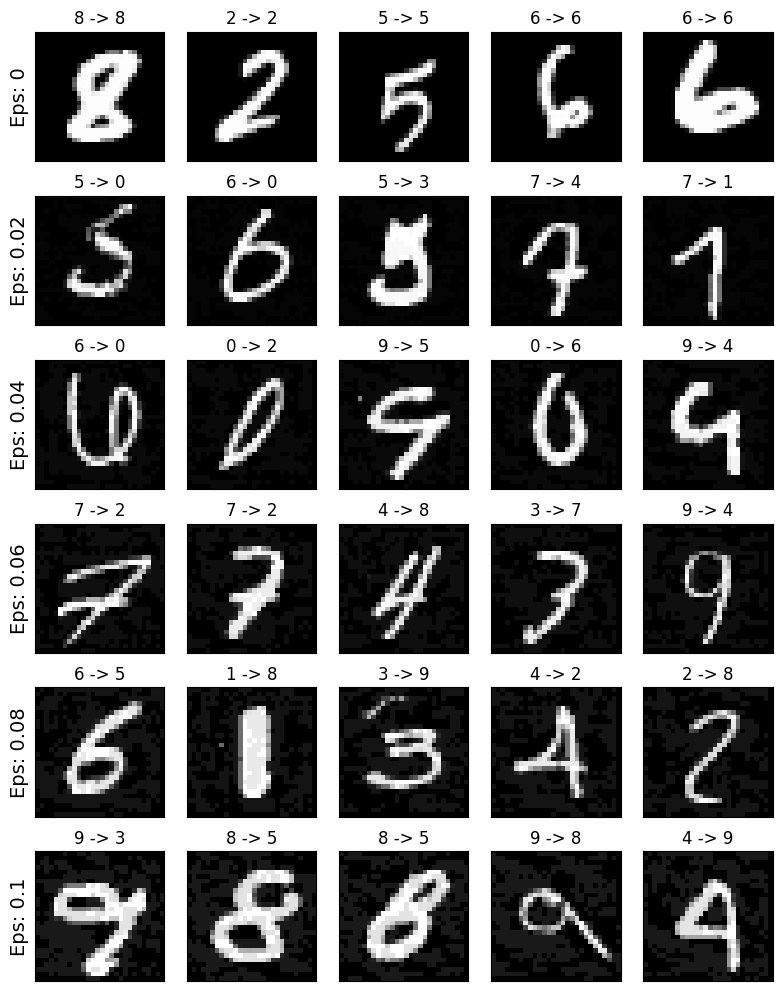

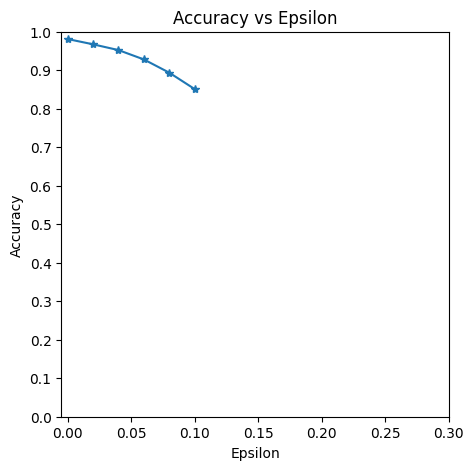

In [1]:
# code from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the network
model = Net().to(device)

# doanload the pretrain model from here: https://drive.google.com/file/d/1KVOHbHnjCd1L-ookcd7CxDqb7rb8-DSx/view?usp=sharing
pretrained_model = "./lenet_mnist_model.pth"
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# TODO: FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # TODO: Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # TODO: Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # TODO: Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # TODO: Set requires_grad attribute of data. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


accuracies = []
examples = []

# TODO: Run test for multiple epsilons
epsilons = [0, 0.02, 0.04, 0.06, 0.08, 0.1]

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


# Part III: Main Computer Vision tasks
* Classification (ResNet, ViT)
* Detection (YOLO v10)
* Instance Segmentation (SAM2)
* Image/Video synthesis (SORA)

###Other not-so classical Computer Vision tasks
* Image/Video description
* Visual Question Answering (VQA)

**Questions**
* <font color='#ED1F24'>**Q:** </font>  What is the formulation for each (input/output/loss/particularities)?

* <font color='#ED1F24'>**Q:** </font> What do you think that changes when you go from Image level to Video level as input?

## YOLO v10


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 15.9M/15.9M [00:00<00:00, 55.8MB/s]


100%|██████████| 49.2k/49.2k [00:00<00:00, 43.3MB/s]


image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 59.6ms
Speed: 21.8ms preprocess, 59.6ms inference, 51.1ms postprocess per image at shape (1, 3, 384, 640)


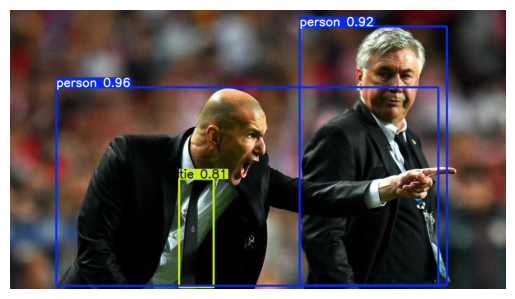

In [2]:
from ultralytics import YOLO
import cv2

model = YOLO('yolov10s.pt') #yolov12 weights here(https://github.com/sunsmarterjie/yolov12?tab=readme-ov-file)

img = 'https://ultralytics.com/images/zidane.jpg'

# Inference
results = model(img)

# Plot the results
annotated_frame = results[0].plot()

# Convert BGR to RGB for matplotlib
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(annotated_frame)
plt.axis('off')
plt.show()

# SegmentAnything (SAM2)

Foundational segmentation model

<div>
<img src= "https://miro.medium.com/v2/resize:fit:1400/format:webp/0*EArMP6AF0n5Oiy1G", width =700>

In [3]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt

  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-xt7ewl25
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-xt7ewl25
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp311-cp311-linux_x86_64.whl size=471040 sha256=2125cf9bfc9bcd40dcbb4a3f8d798306a31dccdf181c7a0a

In [4]:
#display functions
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

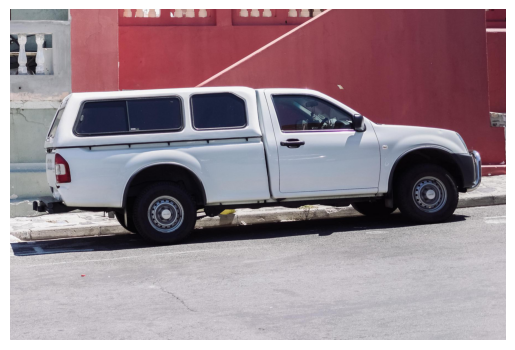

In [7]:
from PIL import Image

image = Image.open('images/truck.jpg')
image = np.array(image.convert("RGB"))
plt.imshow(image)
plt.axis('off')
plt.show()

34
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


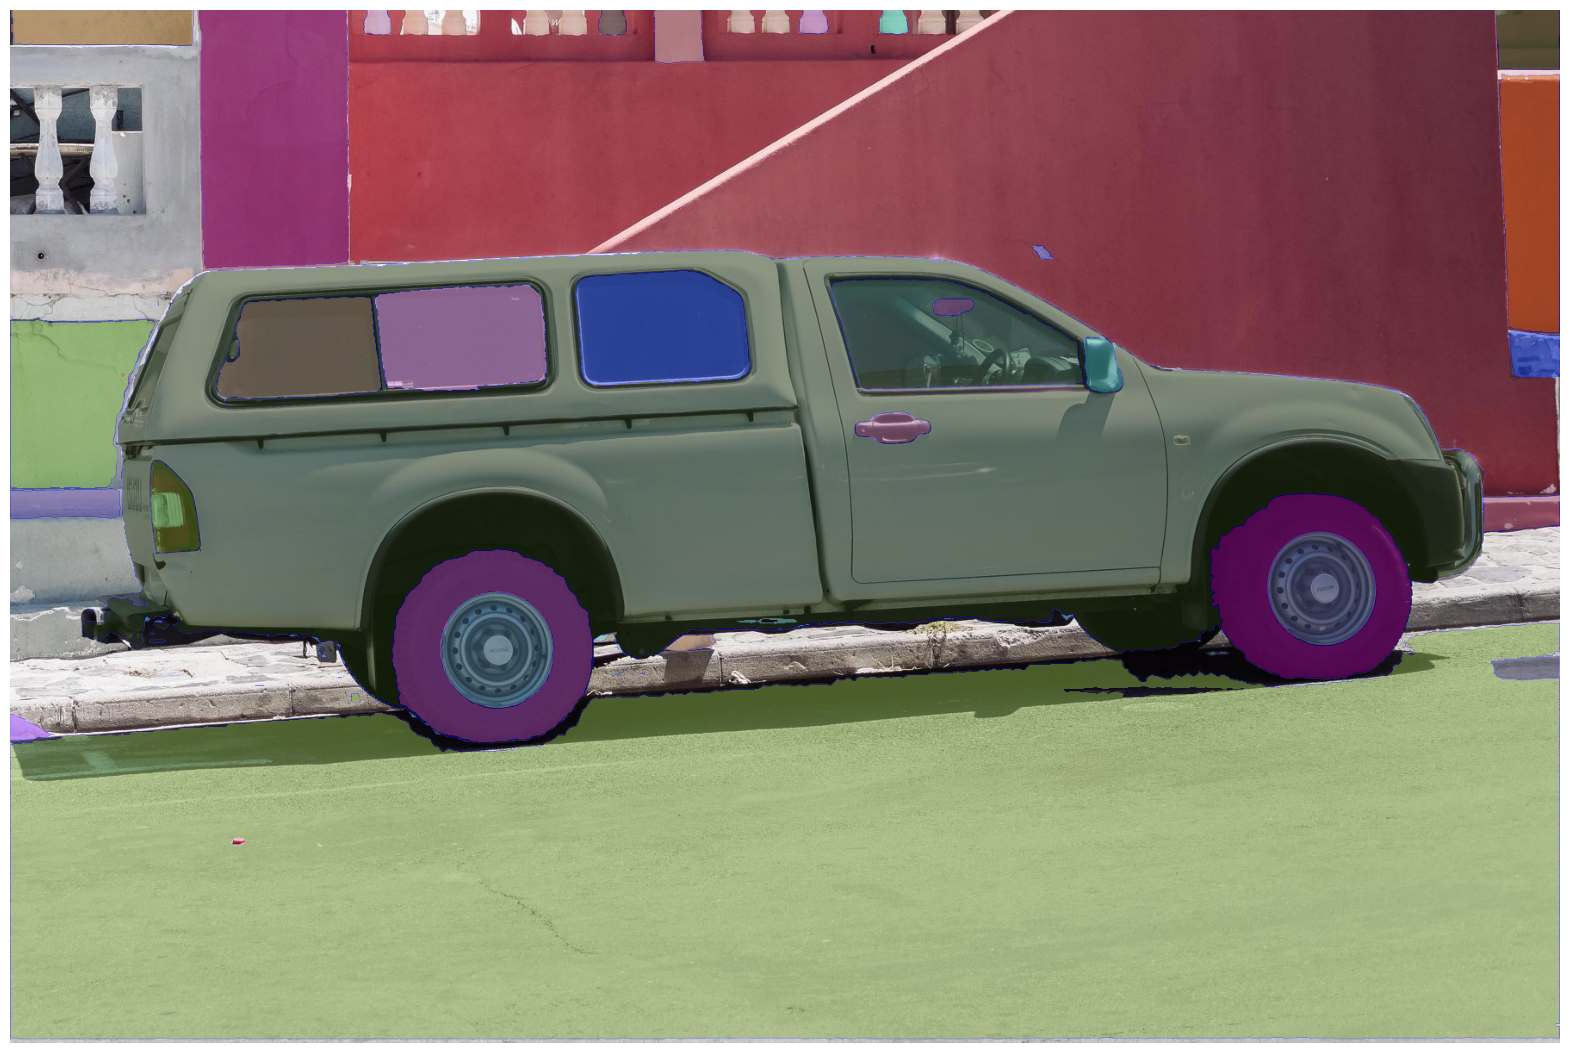

In [8]:
# zero-shot segmentation
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device)
mask_generator = SAM2AutomaticMaskGenerator(sam2)
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [9]:
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2)
predictor.set_image(image)

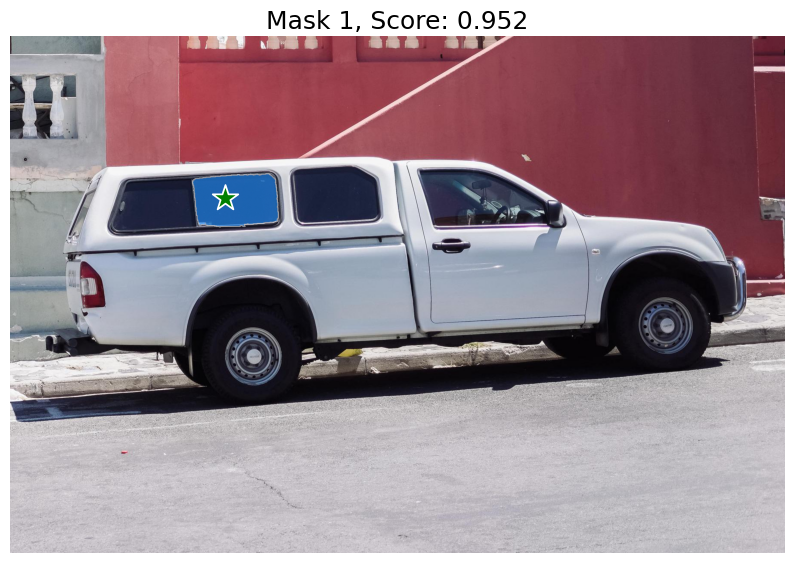

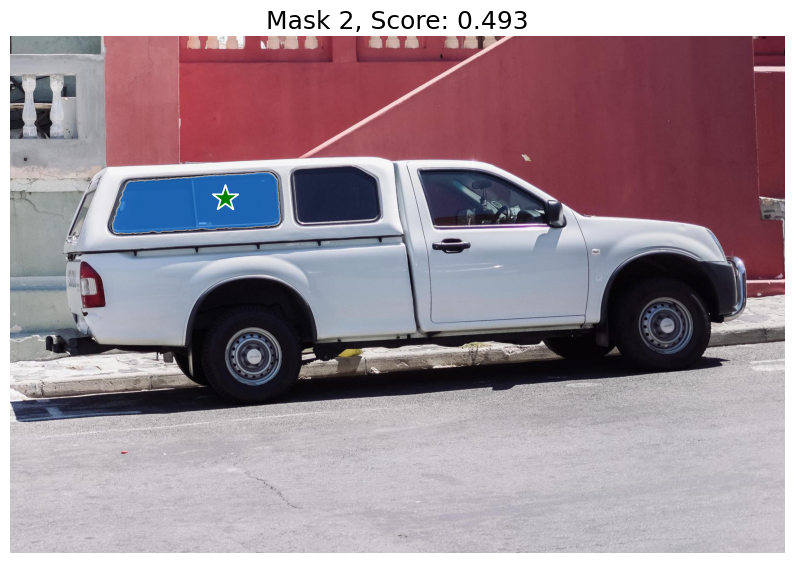

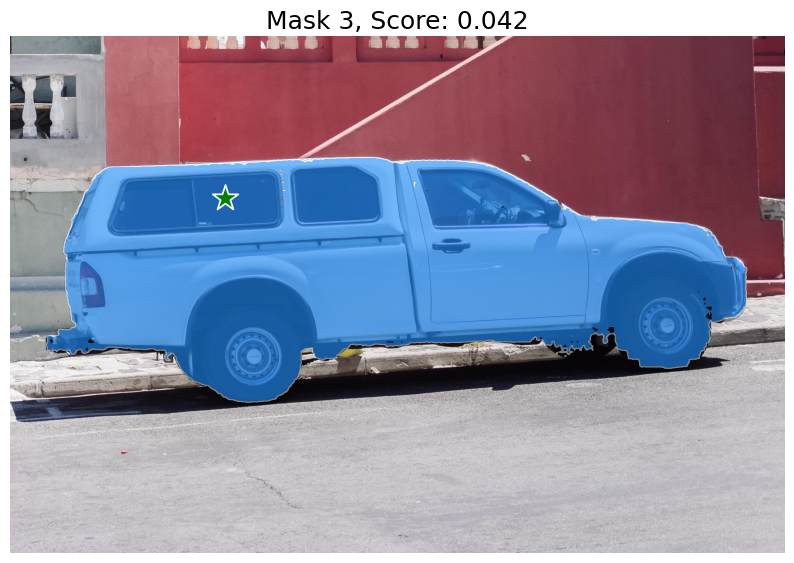

In [10]:
# pointed object segmentation
input_point = np.array([[500, 375]])
input_label = np.array([1]) # foreground points/ point of interest

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

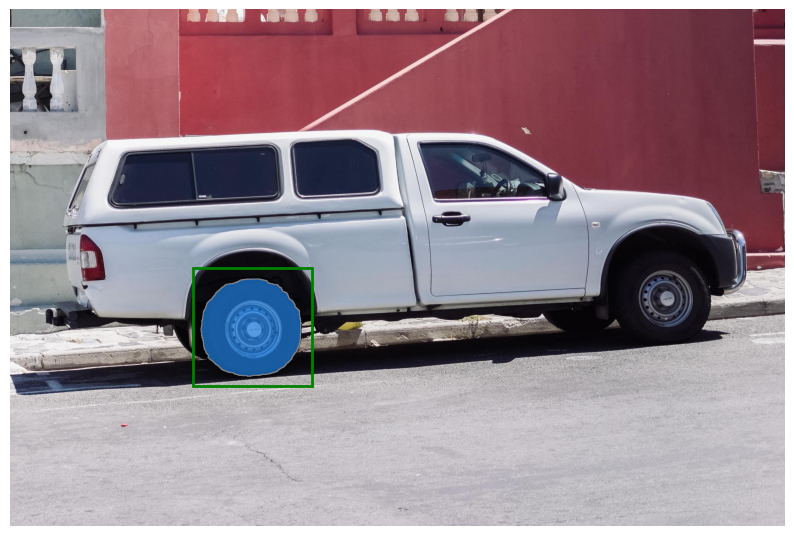

In [11]:
input_box = np.array([425, 600, 700, 875])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

show_masks(image, masks, scores, box_coords=input_box)

# Part IV: Multi-modal models


## CLIP - inference demo


CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. We found CLIP matches the performance of the original ResNet50 on ImageNet “zero-shot” without using any of the original 1.28M labeled examples, overcoming several major challenges in computer vision.


[Paper](https://arxiv.org/abs/2103.00020). Code from [CLIP github](https://github.com/openai/CLIP).


In [12]:
!pip install git+https://github.com/openai/CLIP.git
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input_horse.jpg

import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load("ViT-B/32", device=device)

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bbvveo93
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bbvveo93
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=dfe31a475a7780aa2b3c8d0758c05179924c8ac52492eae7b19ab8996a99a9ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-p0etfqfk/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 109MiB/s]


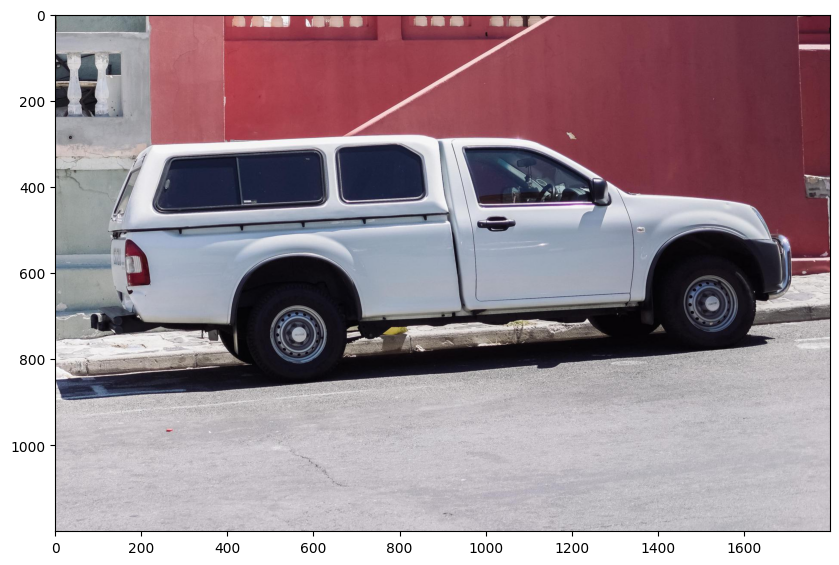

Probabilities:

a diagram: 0.268%
some flowers: 0.003%
van: 21.328%
a horse: 0.422%
truck: 78.000%


In [13]:
text_raw = ["a diagram", "some flowers", "van", "a horse", "truck"]
image_pil = Image.open("images/truck.jpg")
image = preprocess(image_pil).unsqueeze(0).to(device)
text = clip.tokenize(text_raw).to(device)

with torch.no_grad():
    image_features = model_clip.encode_image(image)
    text_features = model_clip.encode_text(text)

    logits_per_image, logits_per_text = model_clip(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(np.array(image_pil))
plt.show()


print("Probabilities:\n")
for text_cls, prob_cls in zip(text_raw, probs[0]):
    print("%s: %.3f%%" % (text_cls, prob_cls*100))

100%|██████████| 169M/169M [00:18<00:00, 9.13MB/s]


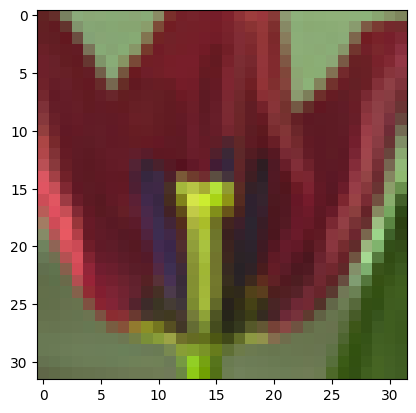


Top predictions:

           tulip: 93.31%
          orchid: 2.19%
    sweet_pepper: 0.83%
            rose: 0.71%
           poppy: 0.56%


In [15]:
from torchvision.datasets import CIFAR100
import os

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Take one image from cifar-100
image, class_id = cifar100[2000]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

plt.figure()
plt.imshow(np.array(image))
plt.show()

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

## Florence-2
Large Vision-Language Model (VLM) with multitask capabilities:
* Image Captioning
* Detection and Segmentation
* OCR

[Paper](https://arxiv.org/abs/2311.06242). [Code](https://github.com/anyantudre/Florence-2-Vision-Language-Model?tab=readme-ov-file)

In [16]:
import requests
from transformers import AutoProcessor, AutoModelForCausalLM


device = "cuda" #"cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True).eval().to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [17]:
import matplotlib.patches as patches

# Florence-2 inference
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

# display function
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

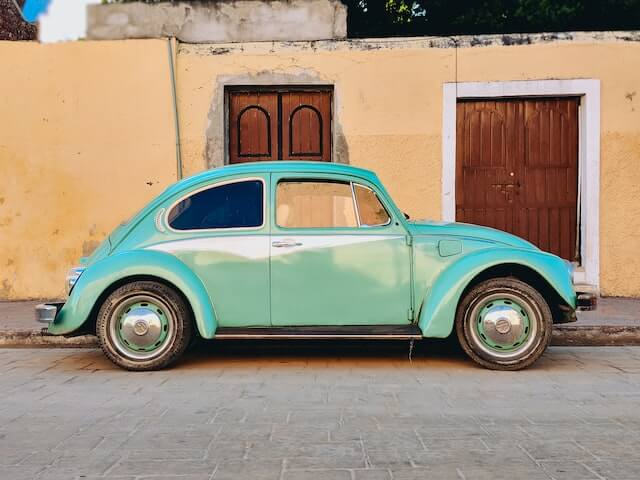

In [18]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)
display(image)

In [19]:
task_prompt = "<DETAILED_CAPTION>"
# Other tasks
# '<OCR>': 'pure_text',
# '<OCR_WITH_REGION>': 'ocr',
# '<CAPTION>': 'pure_text',
# '<DETAILED_CAPTION>': 'pure_text',
# '<MORE_DETAILED_CAPTION>': 'pure_text',
# '<OD>': 'description_with_bboxes',
# '<DENSE_REGION_CAPTION>': 'description_with_bboxes',
# '<CAPTION_TO_PHRASE_GROUNDING>': "phrase_grounding",
# '<REFERRING_EXPRESSION_SEGMENTATION>': 'polygons',
# '<REGION_TO_SEGMENTATION>': 'polygons',
# '<OPEN_VOCABULARY_DETECTION>': 'description_with_bboxes_or_polygons',
# '<REGION_TO_CATEGORY>': 'pure_text',
# '<REGION_TO_DESCRIPTION>': 'pure_text',
# '<REGION_TO_OCR>': 'pure_text',
# '<REGION_PROPOSAL>': 'bboxes'

results = run_example(task_prompt)
print(results)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}


{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234, 159.1199951171875, 582.0800170898438, 374.6399841308594], [1.5999999046325684, 4.559999942779541, 639.0399780273438, 304.55999755859375]], 'labels': ['A green car', 'a yellow building']}}


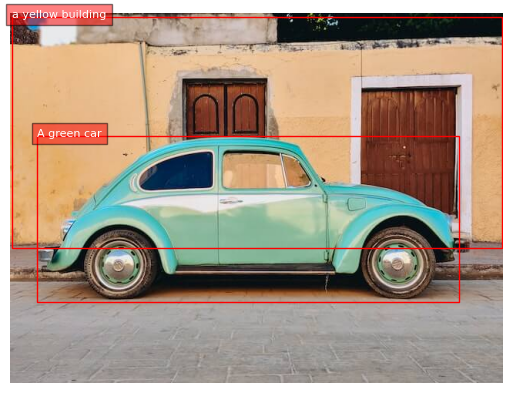

In [20]:
task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
text_input = "A green car parked in front of a yellow building."
# text_input = "A green car parked in front of a double door and a wooden window."

results = run_example(task_prompt, text_input=text_input)
print(results)
plot_bbox(image, results[task_prompt])

<font color='#ED1F24'>**Q:** </font> Choose a Computer Vision task that sounds interesting to you and run it in colab (search in the list bellow or in any other place).


Resources for the models:
* PapersWithCode https://paperswithcode.com/
* ModelZoo https://modelzoo.co/category/computer-vision
* PyTorch Backbones https://pytorch.org/vision/stable/models.html
* PyTorch Hub https://pytorch.org/hub/
* Computer Vision Explorer https://vision-explorer.allenai.org/
* Computer Vision Notebooks: https://www.qblocks.cloud/creators/computer-vision-google-colab-notebooks
* Roboflow: https://models.roboflow.com/
* HuggingFace https://huggingface.co/


<font color='#ED1F24'>**Q:** </font> Share a screenshot with the result.

## Image Colorization

Deep learning for colorizing black and white images.

PyTorch [colab](https://colab.research.google.com/github/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/Image%20Colorization%20with%20U-Net%20and%20GAN%20Tutorial.ipynb).

<div>
<img src=https://drive.google.com/uc?id=1e_SZor5K5g6tPgbt-7PFTFgdCo_METvF  width="700"/>
/>
<div>

## StyleTransfer

Take an image and reproduce it with a new artistic style.

PyTorch [code](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html).

<div>
<img src=https://drive.google.com/uc?id=1Twp9o4h7oryEjPqAKwBcOSML50_pZjLs  width="700"/>
/>
<div>

## CycleGAN

~Unsupervised image-to-image translation.

PyTorch [code](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix).

<div>
<img src=https://drive.google.com/uc?id=1mOD-QdwwInz2YT5b3g1-7CWgXk4yubqd  width="300"/>
<img src=https://drive.google.com/uc?id=1Y4l0ihzVGER0ivdp3WPlmMNpWpgJRIwu width="700"/>

<div>


## Stable Diffusion

PyTorch [code](https://github.com/CompVis/stable-diffusion?tab=readme-ov-file).

Text-to-image generation using latent diffusion

<img src="https://github.com/CompVis/stable-diffusion/raw/main/assets/stable-samples/txt2img/merged-0007.png" width=700>

<img src="https://github.com/CompVis/stable-diffusion/raw/main/assets/stable-samples/txt2img/merged-0005.png" width=700>